### Imports

In [189]:

from typing import Dict, List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import pandas as pd

### File handling functions

In [190]:
def get_initial_file_variables(bnu: bool = True) -> Tuple[str, str]:
    """
    This function returns the file name pattern and file path based on the input parameter.

    Parameters:
        bnu (bool): Determines which pattern and path to use.
                    If True, uses the pattern and path for Blumenau images.
                    If False, uses the pattern and path for Santa Catarina images.

    Returns:
        tuple: A tuple containing the file name regex pattern (str) and the directory path (str).
    """

    if bnu:
        file_name_pattern = r"(\d{1,2})_(\d{4})_BNU_250\.tif"
        files_path = r'./raster_bnu/'
    else:
        file_name_pattern = r"(\d{1,2})_(\d{4})_UTM\.tif"
        files_path = r'./raster/'

    return file_name_pattern, files_path

def get_raw_image_file_paths(file_name_pattern: str, files_path: str, files_to_ignore: List[str] = []) -> List[str]:
    """
    This function retrieves the list of image file paths matching a specific pattern in a given directory.

    Parameters:
        file_name_pattern (str): The regex pattern to identify files of interest.
        files_path (str): The directory where the files are located.
        files_to_ignore (list, optional): A list of file names to exclude from the result. Default is an empty list.

    Returns:
        list: A list of file paths matching the given pattern, excluding ignored files.
    """

    # List all images in the specified path that match the pattern.
    file_paths = [f for f in os.listdir(files_path) if re.match(file_name_pattern, f)]

    # Remove the specified files if they exist.
    file_paths = [f for f in file_paths if f not in files_to_ignore]

    return file_paths

def sort_image_file_paths(images_files: List[str], file_name_pattern: str, files_path: str) -> List[str]:
    """
    This function sorts image files by year and month extracted from their names.

    Parameters:
        images_files (list): A list of image file names to be sorted.
        file_name_pattern (str): The regex pattern used to extract year and month from file names.
        files_path (str): The directory where the image files are located.

    Returns:
        list: A sorted list of file paths, ordered by year (ascending) and month (ascending).
    """

    sorted_files = sorted(
        [os.path.join(files_path, file) for file in images_files if file.endswith('.tif')],
        key=lambda x: (int(re.search(file_name_pattern, x).group(2)), int(re.search(file_name_pattern, x).group(1)))
    )

    return sorted_files

### Plotting functions

In [191]:
def show_all_images(file_name_pattern: str, file_paths: List[str], image_band: int = 3):
    """
    Display a grid of images with month and year labels extracted from file names.

    Parameters:
        file_name_pattern (str): A regex pattern to extract the month and year from the file names.
        file_paths (List[str]): A list of file paths pointing to the images to be displayed.
        image_band (int, optional): The specific band of the image to display. Defaults to 3.

    Returns:
        None

    This function reads image files from the provided paths, extracts metadata (month and year) 
    using a regex pattern, and displays the images in a grid layout. Each image is labeled 
    with its corresponding month and year, and the grid is shown in grayscale.
    """

    # Set up the grid for displaying images.
    fig, axes = plt.subplots(6, 20, figsize=(16, 9))  # Adjust the grid size as needed.
    axes = axes.flatten()

    for index, file in enumerate(file_paths):
        match = re.search(file_name_pattern, file)  # Extract month and year.
        if match:
            month = match.group(1)
            year = match.group(2)

            # Open and read the specified band of the image.
            with rasterio.open(file) as src:
                img = src.read(image_band)
                ax = axes[index]
                ax.imshow(img, cmap='gray')
                ax.set_title(f"{month}/{year}", fontsize=8)  # Label with month/year.
                ax.axis('off')

    plt.tight_layout()
    plt.show()


def show_first_and_last_image_classification_with_svm(first_image, last_image):
    """
    Display the first and last classified images with a colorbar showing 10 intensity classes (0 to 9)
    and an additional legend with colored squares for each class.
    
    Parameters:
        first_image (np.ndarray): The classified first image (2D array).
        last_image (np.ndarray): The classified last image (2D array).
    """

    # Show both images.
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # First image.
    im1 = axes[0].imshow(first_image, cmap='viridis', vmin=0, vmax=9)
    axes[0].set_title("First image")
    axes[0].axis('off')
    cbar1 = plt.colorbar(im1, ax=axes[0], orientation="vertical", ticks=range(10))
    cbar1.set_label("Intensity classes", fontsize=12)
    cbar1.ax.set_yticklabels([str(i) for i in range(10)])

    # Last image.
    im2 = axes[1].imshow(last_image, cmap='viridis', vmin=0, vmax=9)
    axes[1].set_title("Last image")
    axes[1].axis('off')
    cbar2 = plt.colorbar(im2, ax=axes[1], orientation="vertical", ticks=range(10))
    cbar2.set_label("Intensity classes", fontsize=12)
    cbar2.ax.set_yticklabels([str(i) for i in range(10)])

    # Add a custom legend.
    class_colors = [plt.cm.viridis(i / 9) for i in range(10)]  # Normalize the range 0-9 for colormap.
    legend_patches = [
        mpatches.Patch(color=class_colors[i], label=f"Class {i}") for i in range(10)
    ]
    fig.legend(handles=legend_patches, loc='lower center', ncol=10, fontsize=12, title="Classes")

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

def divide_image(image):
    """
    Divide a raster image into three vertical parts (top, middle, bottom) 
    and display them using Matplotlib with consistent color scaling.

    Parameters:
        image (np.ndarray): The input raster image as a NumPy array.
        cmap (str): The colormap to use for displaying the image. Defaults to 'viridis'.

    Returns:
        None
    """

    height, width = image.shape

    middle_height = int(height * 0.1)
    upper_lower_height = int(height * 0.45)

    top = image[:upper_lower_height, :]
    middle = image[upper_lower_height:upper_lower_height + middle_height, :]
    bottom = image[upper_lower_height + middle_height:, :]

    return top, middle, bottom

def show_image_parts(top, middle, bottom, cmap='viridis'):
    """
    Display the separated parts of the image (top, middle, bottom) using Matplotlib.

    Parameters:
        top (np.ndarray): The top portion of the image.
        middle (np.ndarray): The middle portion of the image.
        bottom (np.ndarray): The bottom portion of the image.
        cmap (str): The colormap to use for displaying the image. Defaults to 'viridis'.
        vmin (float, optional): Minimum value for consistent color scaling. Defaults to None.
        vmax (float, optional): Maximum value for consistent color scaling. Defaults to None.

    Returns:
        None
    """

    fig, axes = plt.subplots(
        3, 1, figsize=(8, 12),
        gridspec_kw={"height_ratios": [45, 10, 45]}  # 45%, 10%, 45%
    )

    im1 = axes[0].imshow(top, cmap=cmap, vmin=0, vmax=9)
    axes[0].axis('off')

    im2 = axes[1].imshow(middle, cmap=cmap, vmin=0, vmax=9)
    axes[1].axis('off')

    im3 = axes[2].imshow(bottom, cmap=cmap, vmin=0, vmax=9)
    axes[2].axis('off')

    cbar = fig.colorbar(
        im1,
        ax=axes,
        orientation='vertical',
        fraction=0.05,
        pad=0.05,
        aspect=30,
        ticks=range(10)
    )
    cbar.set_label("Intensity classes", fontsize=12)
    cbar.ax.set_yticklabels([str(i) for i in range(10)])

    fig.subplots_adjust(left=0.2, right=0.85, top=0.95, bottom=0.05, hspace=0.4)

    plt.show()

def plot_region_comparisons(first_counts, last_counts, region_name):
    """
    Plot a comparison of pixel counts by intensity class for a specific region.

    Parameters:
        first_counts (dict): Pixel counts by intensity class (0-9) for the first image region.
        last_counts (dict): Pixel counts by intensity class (0-9) for the last image region.
        region_name (str): Name of the region (e.g., "Top", "Middle", "Bottom").

    Returns:
        None
    """

    # classes = sorted(set(first_counts.keys()).union(last_counts.keys()))
    # classes = sorted(set(k for k in first_counts.keys() if k != 0).union(k for k in last_counts.keys() if k != 0))
    classes = sorted(set(k for k in first_counts.keys()).union(k for k in last_counts.keys()))
    
    first_values = [first_counts.get(cls, 0) for cls in classes]
    last_values = [last_counts.get(cls, 0) for cls in classes]

    x = np.arange(len(classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, first_values, width, label='First Image')
    bars2 = ax.bar(x + width/2, last_values, width, label='Last Image')

    ax.set_title(f'Pixel Count Comparison ({region_name} Region)', fontsize=14)
    ax.set_xlabel('Intensity Class', fontsize=12)
    ax.set_ylabel('Pixel Count', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def plot_illumination_growth(parts_2014, parts_2023):
    parts = [f"Slice {i+1}" for i in range(len(parts_2014))]
    growth = [p2023 - p2014 for p2014, p2023 in zip(parts_2014, parts_2023)]
    
    x = np.arange(len(parts))
    bar_width = 0.35
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, parts_2014, bar_width, label="First image")
    plt.bar(x + bar_width/2, parts_2023, bar_width, label="Last image")
    
    for i, val in enumerate(growth):
        plt.text(x[i], max(parts_2014[i], parts_2023[i]) + 20, f"+{val}", ha='center', fontsize=10, color='green')
    
    plt.title("Illumination Growth in Image Sections")
    plt.xlabel("Image Sections")
    plt.ylabel("Illumination Coefficient")
    plt.xticks(x, parts)
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.show()

def plot_growth_percentage(growth_percentages):
    sections = ["Top", "Middle", "Bottom"]

    plt.figure(figsize=(10, 6))
    plt.bar(sections, growth_percentages, color='skyblue', edgecolor='black')

    for i, value in enumerate(growth_percentages):
        plt.text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=10)

    plt.title("Percentage Growth of Illumination")
    plt.xlabel("Image Sections")
    plt.ylabel("Growth Percentage (%)")
    plt.grid(axis='y', linestyle='--')
    plt.show()

def plot_images_by_year(images: List[np.ndarray], start_year: int = 2014):
    """
    Plots up to 10 images from a list of ndarrays in a grid layout, labeling them by year.

    Parameters:
        images (List[np.ndarray]): A list of numpy arrays representing the images to display.
        start_year (int, optional): The starting year for labeling the images. Defaults to 2014.

    Returns:
        None

    This function displays up to 10 images from the provided list in a 2x5 grid.
    Each image is labeled with a year, starting from `start_year` and incrementing for each image.
    """
    
    # Ensure we only plot up to 10 images.
    num_images = min(len(images), 10)
    grid_rows = 2
    grid_cols = 5

    # Set up the grid for displaying images.
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')  # Display the image in grayscale.
        ax.set_title(f"Ano {start_year + i}", fontsize=10)  # Generate title based on year.
        ax.axis('off')  # Turn off axis ticks and labels.

    # Hide any unused axes.
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


def generate_new_pixels_with_threshold(image1: np.ndarray, image2: np.ndarray, min_brightness: int = 0):
    """
    Generates a new image showing only the pixels that didn't exist (value 0) in the first image
    and appeared (greater than min_brightness) in the second image.

    Parameters:
        image1 (np.ndarray): The first image.
        image2 (np.ndarray): The second image.
        min_brightness (int, optional): The minimum brightness for a pixel in the second image to be considered. Defaults to 0.

    Returns:
        np.ndarray: The resulting image with the specified condition applied.
    """

    new_pixels_mask = (image1 < min_brightness) & (image2 > min_brightness)

    # Create the new image with only those pixels.
    new_image = np.zeros_like(image1)
    new_image[new_pixels_mask] = image2[new_pixels_mask]

    return new_image

def compare_and_plot_images_with_threshold(image1: np.ndarray, image2: np.ndarray, min_brightness: int = 0):
    """
    Compares two images, generates a third image based on the condition (new pixels with brightness threshold),
    and plots all three images.

    Parameters:
        image1 (np.ndarray): The first image.
        image2 (np.ndarray): The second image.
        min_brightness (int, optional): The minimum brightness for a pixel in the second image to be considered. Defaults to 0.

    Returns:
        None
    """
    
    # Generate the third image.
    new_image = generate_new_pixels_with_threshold(image1, image2, min_brightness)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title("First image")
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title("Last image")
    axes[1].axis('off')

    axes[2].imshow(new_image, cmap='viridis')
    axes[2].set_title(f"Generated Image")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

### Data management functions

In [192]:
def get_images_grouped_by_year(file_name_pattern: str, file_paths: List[str], image_band: int = 1) -> Dict[str, List[np.ndarray]]:
    """
    Groups images by year and reads their data for further processing in grayscale.

    Parameters:
        file_name_pattern (str): A regex pattern to extract the year from file names.
        file_paths (list): A list of file paths to be grouped by year.
        image_band (int, optional): The specific image band to read from each file. Defaults to 1.

    Returns:
        dict: A dictionary where keys are years (str) and values are lists of grayscale image arrays corresponding to that year.
    """

    yearly_images: Dict[str, List[np.ndarray]] = {}

    for file in file_paths:
        match = re.search(file_name_pattern, file)
        year = match.group(2)
        
        if year not in yearly_images:
            yearly_images[year] = []
        
        with rasterio.open(file) as src:
            img = src.read(image_band)
            yearly_images[year].append(img)

    return yearly_images

def convert_yearly_average_images_dict_to_list(
    yearly_average_images: Dict[str, Dict[str, object]]
) -> Tuple[List[np.ndarray], List[Image.Image]]:
    """
    Retrieve all images from a dictionary of yearly average images.

    Parameters:
        yearly_average_images (dict): A dictionary where keys are years (str) and values are dictionaries containing:
                                      - 'average_image': The average image as a NumPy array.
                                      - 'average_image_pil': The average image as a PIL image.

    Returns:
        tuple: A tuple containing:
               - A list of all NumPy arrays (average_image).
               - A list of all PIL images (average_image_pil).
    """

    all_images = []
    all_images_pil = []

    for year, image_data in yearly_average_images.items():
        all_images.append(image_data['average_image'])
        all_images_pil.append(image_data['average_image_pil'])

    return all_images, all_images_pil

def weighted_sum(dictionary):
    """
    Calculates the weighted sum of the values in a dictionary.
    The key of the dictionary is the weight, and the value is the quantity associated with that weight.

    Args:
        dictionary (dict): Dictionary with the key as the weight (int) and the value as the quantity (int).

    Returns:
        int: Weighted sum (illumination coefficient).
    """
    
    return sum(key * value for key, value in dictionary.items())

### Image processing functions

In [193]:
def calculate_average_image(images: List[np.ndarray]) -> np.ndarray:
    """
    Calculate the average image from a list of images.

    Parameters:
        images (List[np.ndarray]): A list of image arrays.

    Returns:
        np.ndarray: The average image as a numpy array.
    """

    mean_image = np.mean(images, axis=0)
    return mean_image

def calculate_yearly_average_images(images_grouped_by_year: Dict[str, List[np.ndarray]], should_add_year_label: bool = False) -> Dict[str, Dict[str, object]]:
    """
    Calculate the average image for each year from a dictionary of images grouped by year and convert it to PIL format with year labels.

    Parameters:
        images_grouped_by_year (dict): A dictionary where keys are years (str) and values are lists of image arrays corresponding to that year.

    Returns:
        dict: A dictionary where keys are years (str) and values are dictionaries containing:
              - 'average_image': The average image as a NumPy array.
              - 'average_image_pil': The average image as a PIL image with the year annotated.
    """

    average_images: Dict[str, Dict[str, object]] = {}

    for year, images in images_grouped_by_year.items():
        mean_image = calculate_average_image(images)

        # Convert the mean image to PIL format.
        pil_image = Image.fromarray((mean_image / mean_image.max() * 255).astype(np.uint8)).convert("RGB")
        draw = ImageDraw.Draw(pil_image)

        if should_add_year_label:
            # Add the year label.
            try:
                font = ImageFont.truetype("arial.ttf", 20)
            except IOError:
                font = ImageFont.load_default()

            text = f"Year: {year}"
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            text_position = ((pil_image.width - text_width) // 2, 10)
            draw.text(text_position, text, fill="white", font=font)

        # Store both the mean image and its PIL version in the dictionary.
        average_images[year] = {
            'average_image': mean_image,
            'average_image_pil': pil_image
        }

    return average_images

import numpy as np

def count_pixels_by_categorized_intensity(image):
    """
    Count the number of pixels in each categorized intensity class for a given image.

    Parameters:
        image (np.ndarray): A 2D NumPy array representing the image with pixel intensities (0-255).

    Returns:
        dict: A dictionary where keys are intensity categories (0-9) and values are the pixel counts.
    """

    intensity_counts = {i: 0 for i in range(10)}

    for pixel in image.flatten():
        intensity_counts[pixel] += 1

    return intensity_counts

### Gif functions

In [194]:
def save_gif(images, gif_path):
    """
    Save a sequence of images as an animated GIF.

    Parameters:
        images (list of PIL.Image.Image): A list of PIL Image objects to be saved as frames in the GIF.
        gif_path (str): The file path where the GIF will be saved.

    Returns:
        None

    This function saves the first image and appends the remaining images as frames 
    to create an animated GIF. The GIF will loop infinitely with a duration of 
    1 second (1000 ms) per frame.
    """

    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=1000, loop=0)
    print(f"GIF saved as {gif_path}")

### Support Vector Machine (SVM) functions

In [195]:
def categorize_intensity(value: int):
    """
    Categorize an intensity value into one of 10 classes.

    Parameters:
        value (int): The intensity value to be categorized.

    Returns:
        int: The category index (0-9) that the intensity value belongs to.

    Raises:
        ValueError: If the intensity value is not between 0 and 255.
    """

    if value < 0 or value > 255:
        raise ValueError("Value must be between 0 and 255.")
    
    step = 255 / 10
    category = int(value // step)

    return min(category, 9)

def prepare_svm_data(yearly_average_images):
    """
    Prepare the data for an SVM model.

    Parameters:
        yearly_average_images (list): A list of PIL images representing the average images for each year.

    Returns:
        tuple: A tuple containing two numpy arrays. The first array contains the pixel data (features) and the second array contains the labels (classes).

    Raises:
        ValueError: If the input list is empty or if the images are not grayscale.
    """

    pixel_data = []
    labels = []

    for img in yearly_average_images:
        img_gray = img.convert("L")
        img_array = np.array(img_gray)

        for row in img_array:
            for pixel in row:
                pixel_data.append(pixel)
                labels.append(categorize_intensity(pixel))

    pixel_data = np.array(pixel_data).reshape(-1, 1)
    labels = np.array(labels)

    return pixel_data, labels

def create_svm_model():
    """
    Create and return a linear SVM model.

    This function initializes an SVM model using a linear kernel and a fixed random state for reproducibility.

    Returns:
        svm_model (SVC): A newly created instance of the SVC class with a linear kernel.
    """

    svm_model = SVC(kernel='linear', random_state=42)
    return svm_model

def train_svm_model(svm_model: SVC, X_train, y_train):
    """
    Train an SVM model using the provided training data.

    Parameters:
        svm_model (SVC): An untrained SVM model (instance of sklearn's SVC class).
        X_train (array-like): Training dataset features.
        y_train (array-like): True labels corresponding to the training dataset.

    Returns:
        None

    The function performs the following:
        1. Fits the provided SVM model (svm_model) to the training data (X_train and y_train).
        2. Prints status messages indicating the start and completion of training.
    """

    print("Training SVM model...")
    svm_model.fit(X_train, y_train)
    print("Training completed.")

def test_svm_model(svm_model: SVC, X_test, y_test, should_print_evaluation_metrics: bool = True):
    """
    Evaluate a trained SVM model on the test data and return the predictions.

    Parameters:
        svm_model (SVC): A trained SVM model (instance of sklearn's SVC class).
        X_test (array-like): Test dataset features used for evaluation.
        y_test (array-like): True labels for the test dataset.

    Returns:
        y_pred (array-like): Predicted labels for the test dataset.

    The function performs the following:
        1. Predicts labels for the test dataset using the provided SVM model.
        2. Prints a detailed classification report including:
           - Precision, recall, F1-score, and support for each class.
        3. Prints the overall accuracy score of the model.
    """

    y_pred = svm_model.predict(X_test)
    
    if (should_print_evaluation_metrics):
        print("Model evaluation:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    
    return y_pred

def classify_image_pixels_with_svm(svm_model: SVC, image: Image.Image):
    """
    Classify the pixels of an image using a trained SVM model.

    Parameters:
        svm_model (SVC): A trained SVM model.
        image (PIL.Image.Image): The input image to classify.

    Returns:
        np.ndarray: The classified image reshaped to its original dimensions.
    """

    print("Classifying image pixels...")

    img = image.convert("L")
    original_size = img.size
    img = np.array(img).reshape(-1, 1)

    classified_pixels = svm_model.predict(img)
    classified_image = classified_pixels.reshape((original_size[1], original_size[0]))

    return classified_image


### Control variables

In [196]:
image_band = 3
enable_bnu = True

### Initial file handling

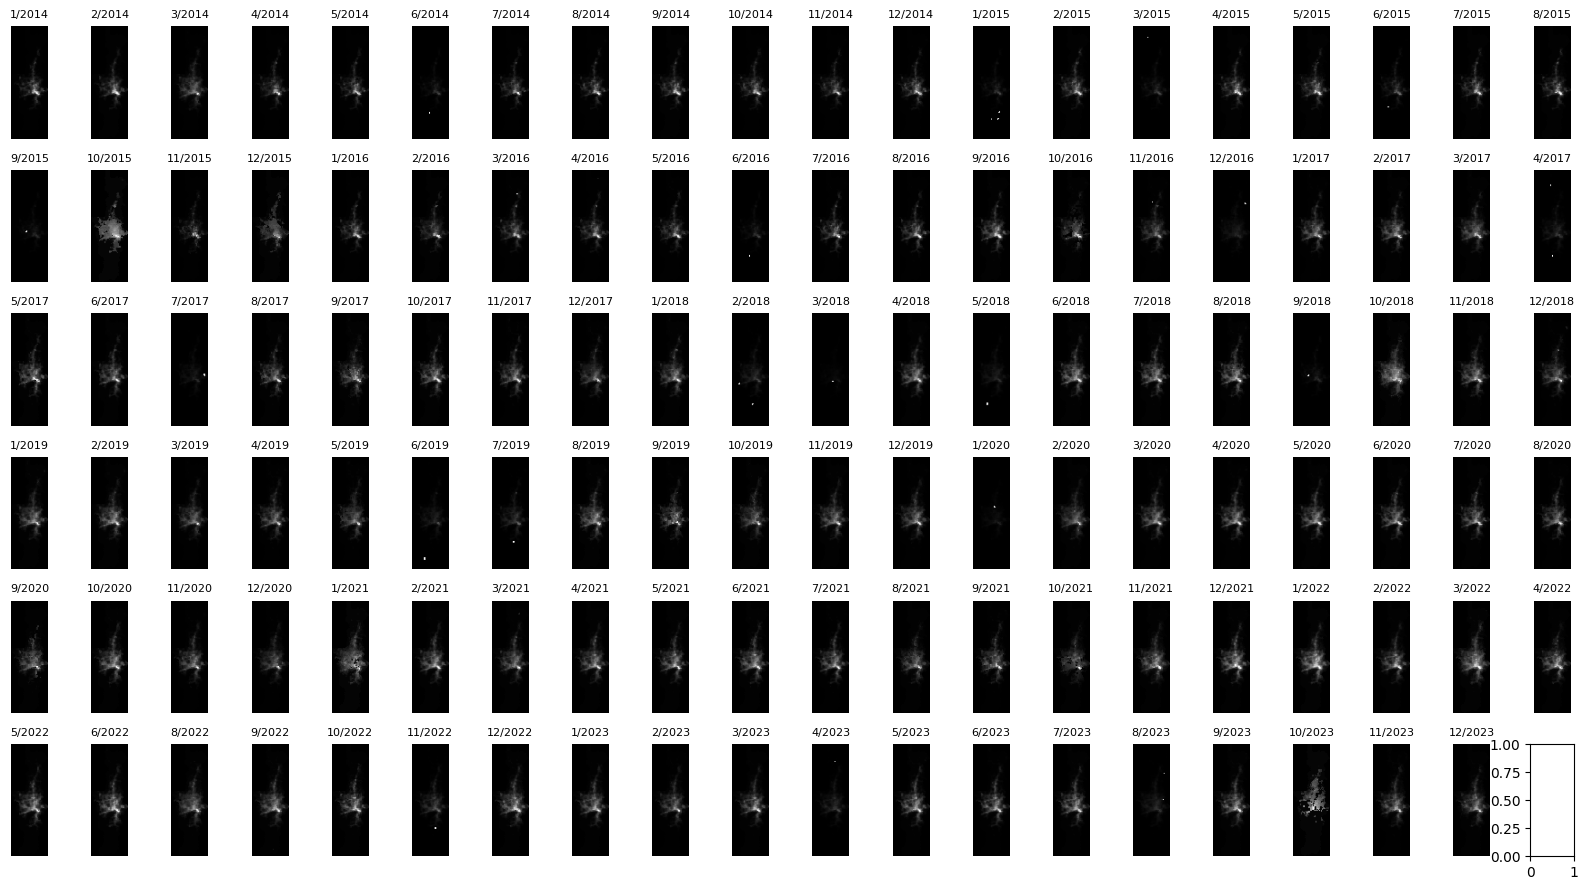

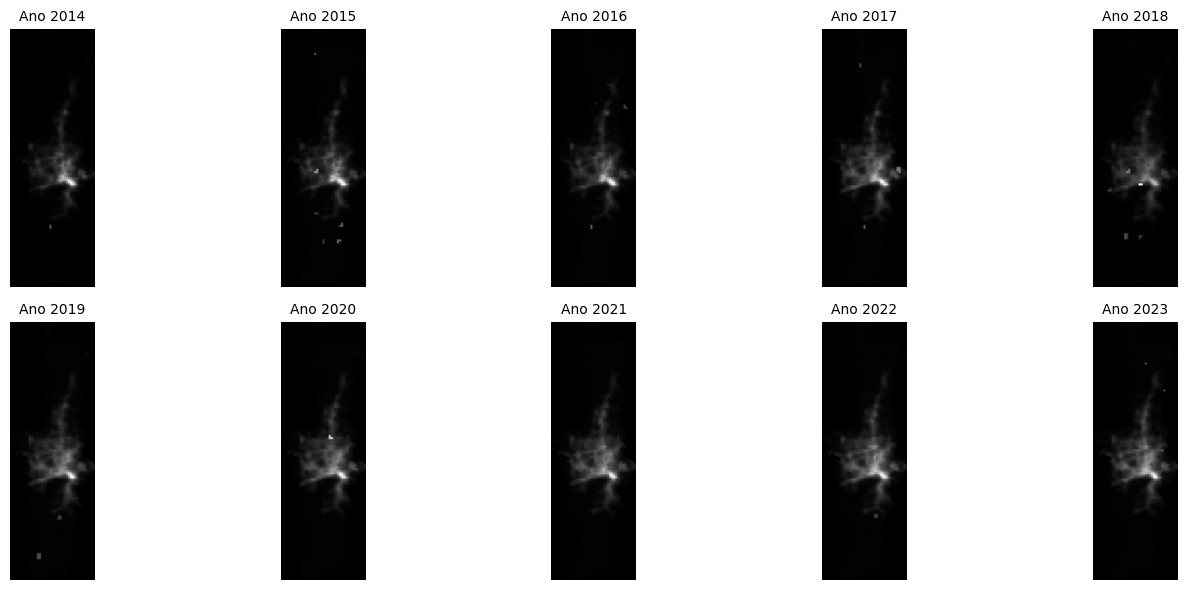

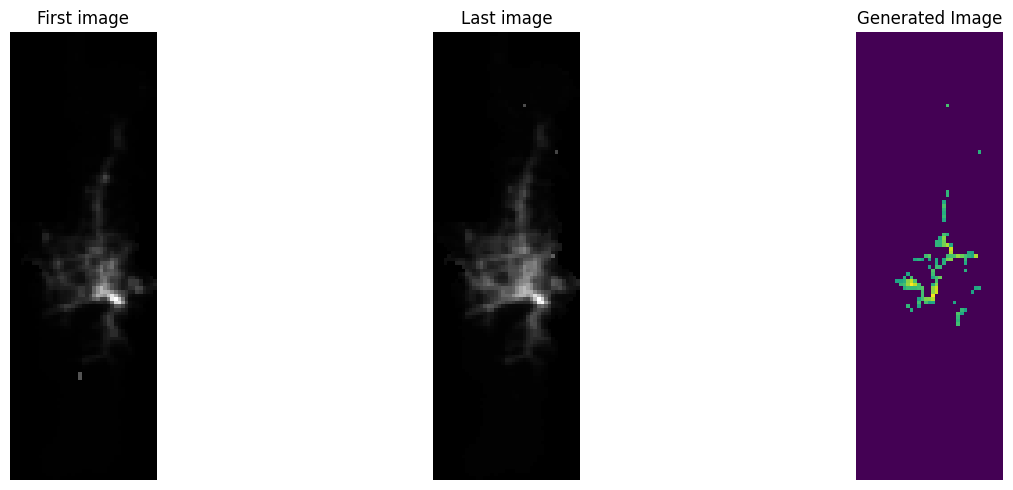

In [197]:
file_name_pattern, files_path = get_initial_file_variables(enable_bnu)

file_paths = get_raw_image_file_paths(file_name_pattern, files_path, ["7_2022_BNU_250.tif", "07_2022_UTM.tif"])
file_paths = sort_image_file_paths(file_paths, file_name_pattern, files_path)

show_all_images(file_name_pattern, file_paths, image_band)

images_grouped_by_year = get_images_grouped_by_year(file_name_pattern, file_paths, image_band)
yearly_average_images_dict = calculate_yearly_average_images(images_grouped_by_year, False)

yearly_average_images, yearly_average_images_pil = convert_yearly_average_images_dict_to_list(yearly_average_images_dict)

plot_images_by_year(yearly_average_images, 2014)

first_image = yearly_average_images[0]
last_image = yearly_average_images[-1]

first_image_pil = yearly_average_images_pil[0]
last_image_pil = yearly_average_images_pil[-1]

compare_and_plot_images_with_threshold(first_image, last_image, min_brightness=26)

### Support Vector Machine (SVM)

In [198]:
pixel_data, labels = prepare_svm_data(yearly_average_images_pil)

X_train, X_test, y_train, y_test = train_test_split(
    pixel_data, labels, test_size=0.3, random_state=42
)

svm_model = create_svm_model()
train_svm_model(svm_model, X_train, y_train)

y_pred = test_svm_model(svm_model, X_test, y_test, False)

first_image_classified_with_svm = classify_image_pixels_with_svm(svm_model, first_image_pil)
last_image_classified_with_svm = classify_image_pixels_with_svm(svm_model, last_image_pil)

Training SVM model...
Training completed.
Classifying image pixels...
Classifying image pixels...


### Plotting

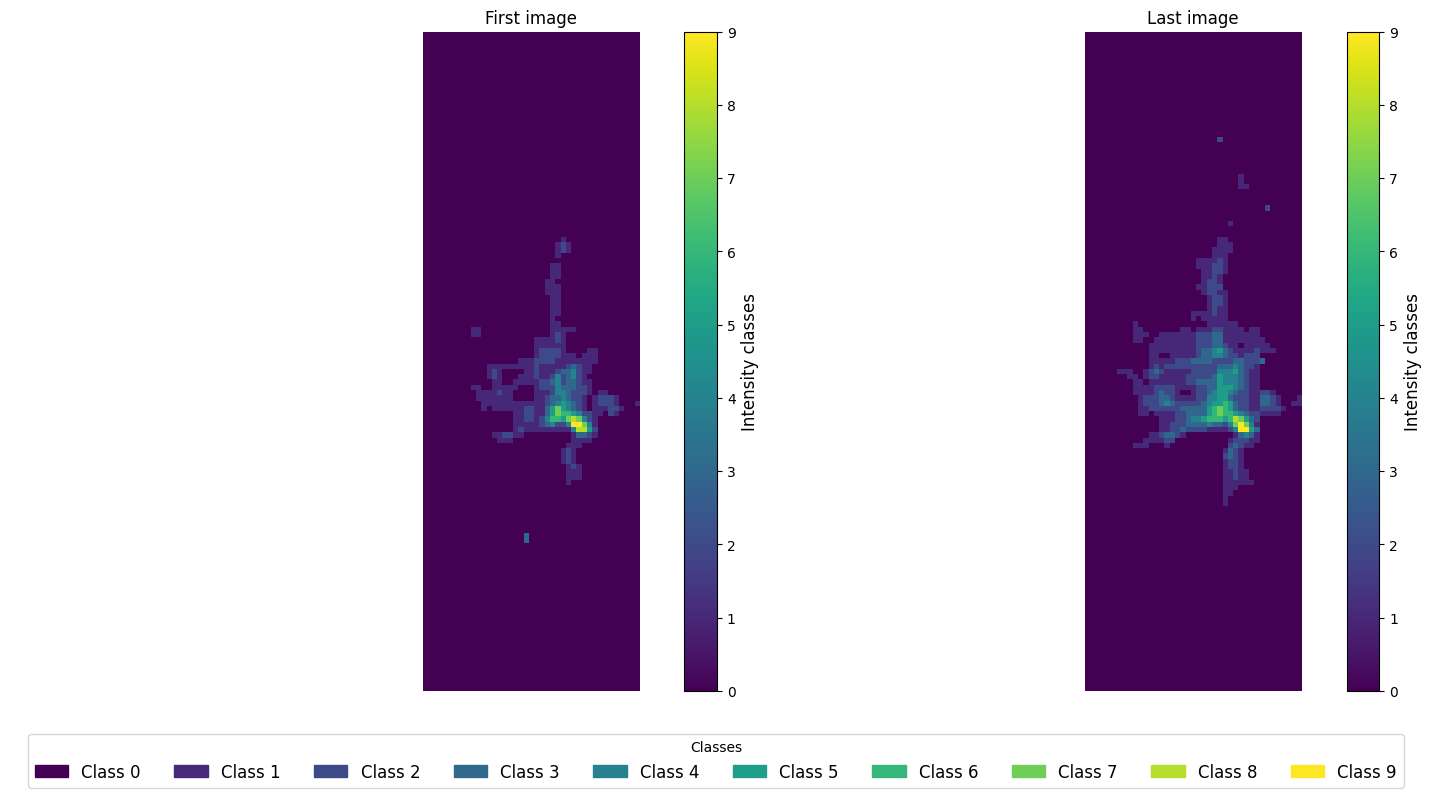

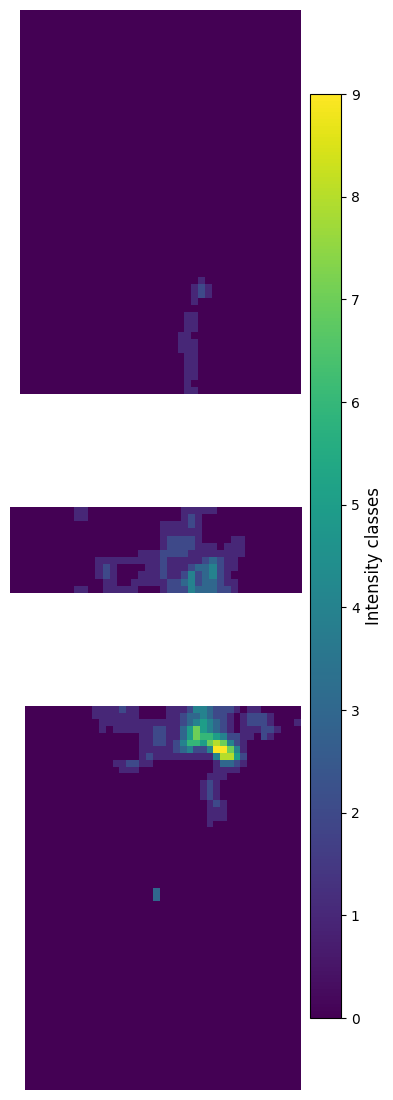

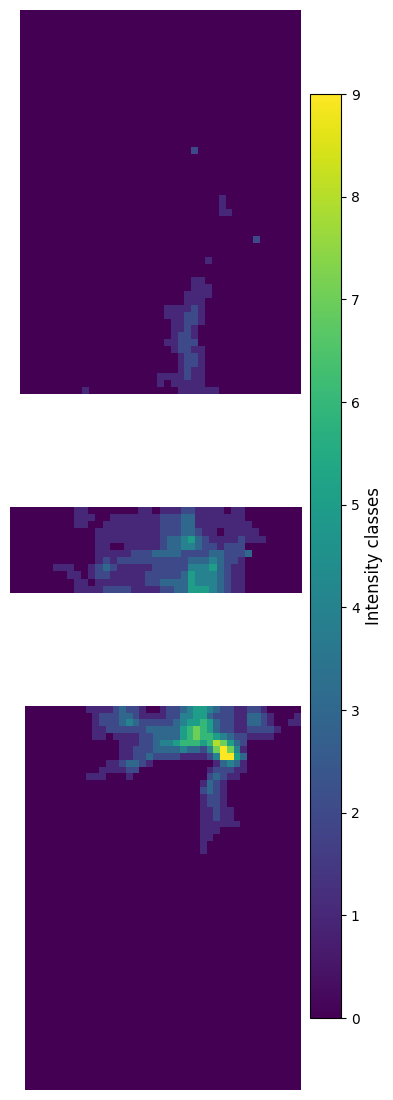

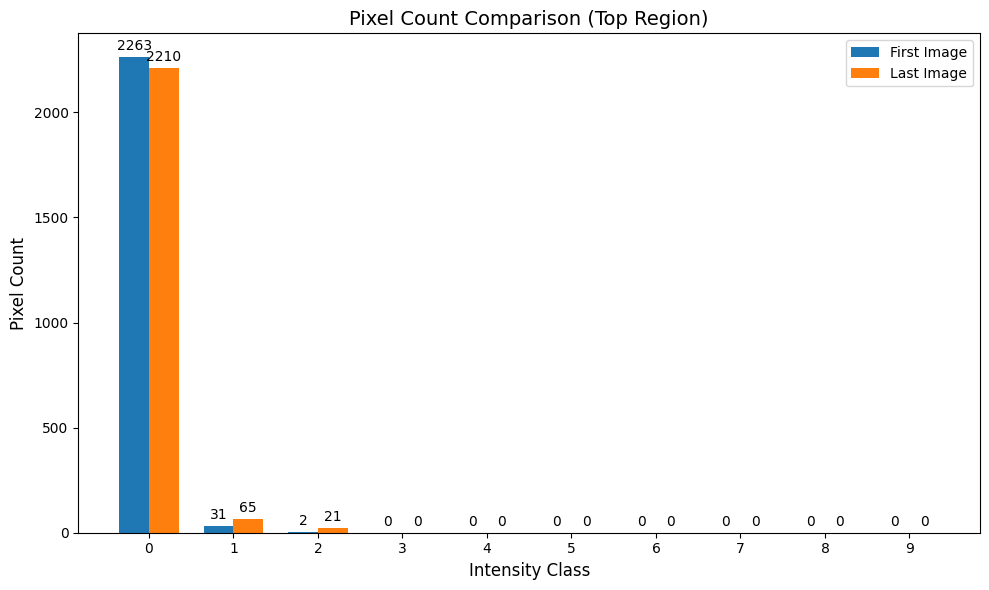

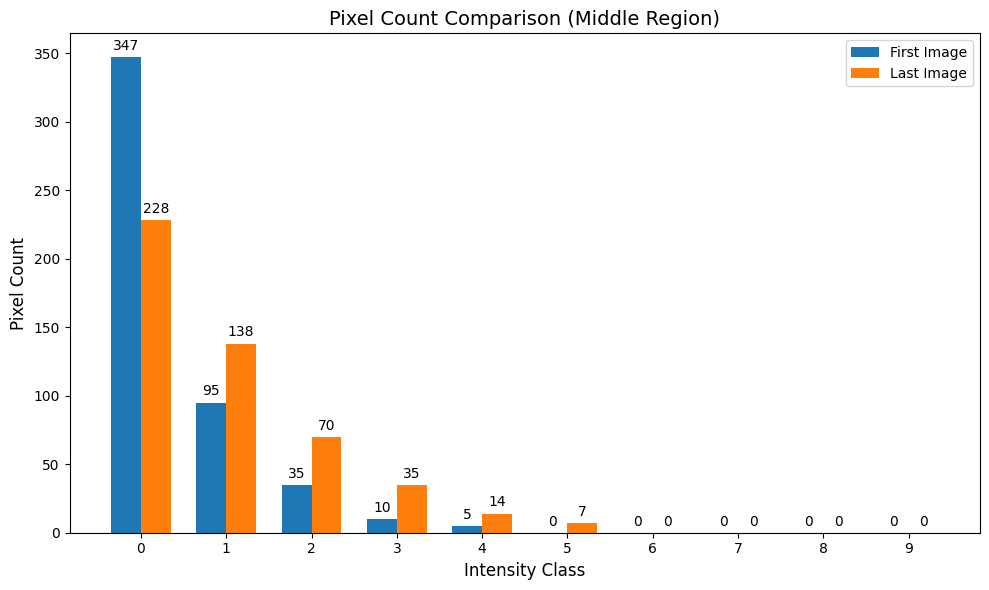

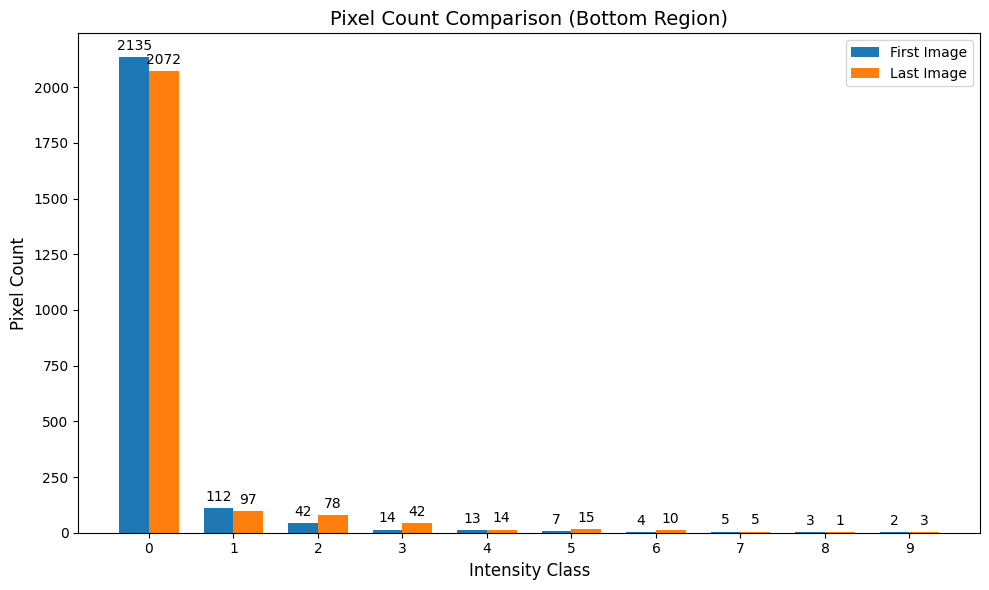

In [199]:
show_first_and_last_image_classification_with_svm(first_image_classified_with_svm, last_image_classified_with_svm)

first_top, first_middle, first_bottom = divide_image(first_image_classified_with_svm)
last_top, last_middle, last_bottom = divide_image(last_image_classified_with_svm)

show_image_parts(first_top, first_middle, first_bottom)
show_image_parts(last_top, last_middle, last_bottom)

first_top_pixels_count = count_pixels_by_categorized_intensity(first_top)
first_middle_pixels_count = count_pixels_by_categorized_intensity(first_middle)
first_bottom_pixels_count = count_pixels_by_categorized_intensity(first_bottom)

last_top_pixels_count = count_pixels_by_categorized_intensity(last_top)
last_middle_pixels_count = count_pixels_by_categorized_intensity(last_middle)
last_bottom_pixels_count = count_pixels_by_categorized_intensity(last_bottom)

plot_region_comparisons(first_top_pixels_count, last_top_pixels_count, "Top")
plot_region_comparisons(first_middle_pixels_count, last_middle_pixels_count, "Middle")
plot_region_comparisons(first_bottom_pixels_count, last_bottom_pixels_count, "Bottom")

### Illumination coeffs

{0: 2263, 1: 31, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
35
{0: 2210, 1: 65, 2: 21, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
107

{0: 347, 1: 95, 2: 35, 3: 10, 4: 5, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
215
{0: 228, 1: 138, 2: 70, 3: 35, 4: 14, 5: 7, 6: 0, 7: 0, 8: 0, 9: 0}
474

{0: 2135, 1: 112, 2: 42, 3: 14, 4: 13, 5: 7, 6: 4, 7: 5, 8: 3, 9: 2}
426
{0: 2072, 1: 97, 2: 78, 3: 42, 4: 14, 5: 15, 6: 10, 7: 5, 8: 1, 9: 3}
640


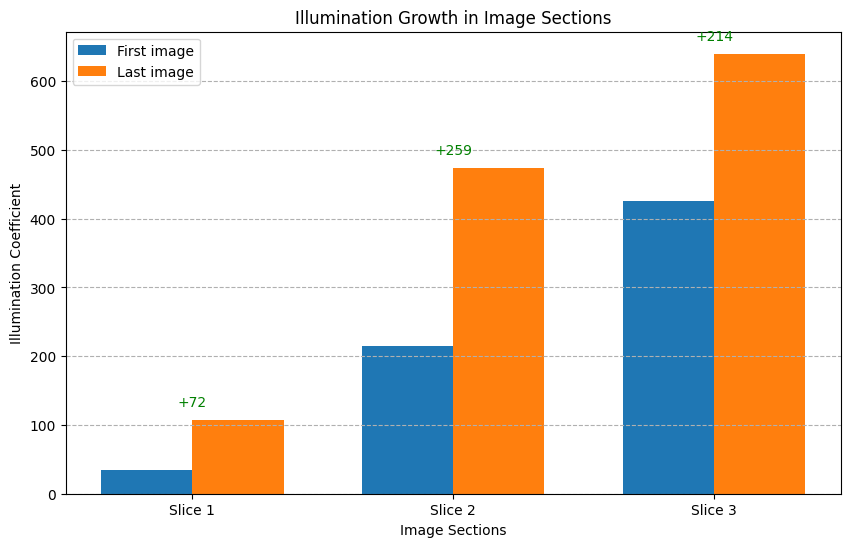

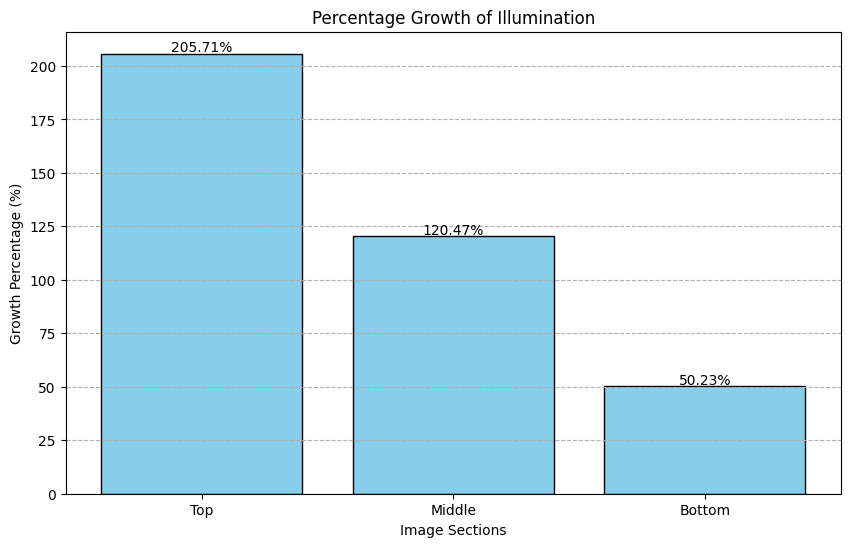

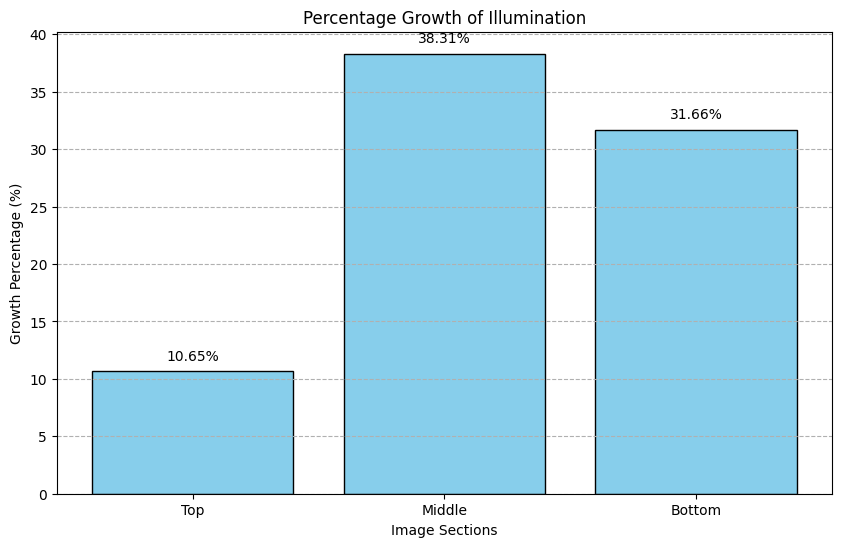

In [204]:
first_top_pixels_illumination_coeff = weighted_sum(first_top_pixels_count)
last_top_pixels_illumination_coeff = weighted_sum(last_top_pixels_count)

first_middle_pixels_illumination_coeff = weighted_sum(first_middle_pixels_count)
last_middle_pixels_illumination_coeff = weighted_sum(last_middle_pixels_count)

first_bottom_pixels_illumination_coeff = weighted_sum(first_bottom_pixels_count)
last_bottom_pixels_illumination_coeff = weighted_sum(last_bottom_pixels_count)

print(first_top_pixels_count)
print(first_top_pixels_illumination_coeff)

print(last_top_pixels_count)
print(last_top_pixels_illumination_coeff)
print("")
print(first_middle_pixels_count)
print(first_middle_pixels_illumination_coeff)

print(last_middle_pixels_count)
print(last_middle_pixels_illumination_coeff)
print("")
print(first_bottom_pixels_count)
print(first_bottom_pixels_illumination_coeff)

print(last_bottom_pixels_count)
print(last_bottom_pixels_illumination_coeff)

illumination_first_image_slices = [first_top_pixels_illumination_coeff, first_middle_pixels_illumination_coeff, first_bottom_pixels_illumination_coeff]
illumination_last_image_slices = [last_top_pixels_illumination_coeff, last_middle_pixels_illumination_coeff, last_bottom_pixels_illumination_coeff]

plot_illumination_growth(illumination_first_image_slices, illumination_last_image_slices)

growth_percentages_self = [
    ((last_top_pixels_illumination_coeff - first_top_pixels_illumination_coeff) / first_top_pixels_illumination_coeff) * 100,
    ((last_middle_pixels_illumination_coeff - first_middle_pixels_illumination_coeff) / first_middle_pixels_illumination_coeff) * 100,
    ((last_bottom_pixels_illumination_coeff - first_bottom_pixels_illumination_coeff) / first_bottom_pixels_illumination_coeff) * 100
]

growth_percentages_bnu = [
    ((last_top_pixels_illumination_coeff - first_top_pixels_illumination_coeff) / (first_top_pixels_illumination_coeff + first_middle_pixels_illumination_coeff + first_bottom_pixels_illumination_coeff)) * 100,
    ((last_middle_pixels_illumination_coeff - first_middle_pixels_illumination_coeff) / (first_top_pixels_illumination_coeff + first_middle_pixels_illumination_coeff + first_bottom_pixels_illumination_coeff)) * 100,
    ((last_bottom_pixels_illumination_coeff - first_bottom_pixels_illumination_coeff) / (first_top_pixels_illumination_coeff + first_middle_pixels_illumination_coeff + first_bottom_pixels_illumination_coeff)) * 100
]

plot_growth_percentage(growth_percentages_self)
plot_growth_percentage(growth_percentages_bnu)